In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns

In [2]:
fq = pd.read_csv(r'C:\Users\John\OneDrive\Desktop\GxDR_Data\FQ_analysis\GMDR_FQ.csv')
anpp= pd.read_csv('GMDR_ANPP_13Dec21.csv')
robel= pd.read_csv('GMDR_ROBEL_2021.csv', parse_dates= {"Date1" : ["Year","Month","Date"]})
clips= pd.read_csv('GMDR_ExitClips.csv')

# ANPP

Create list of columns for smaller anpp table

In [3]:
anppcols=['Date', 'Year', 'Drought', 'Grazing', 'PlotID', 'C3P(g)', 'C4P(g)', 
      'Forb(g)','Standing Dead(g)', 'Vulpia(g)', 'Bromus(g)']
anpp=anpp[anppcols]

In [4]:
# Convert NaN values to the string 'nan' in order to be able to interpret with dictionary below
anpp['Date'][anpp['Date'].isna()]= 'nan'
anpp['Date'][anpp['Date']=='nan']

108    nan
109    nan
110    nan
111    nan
112    nan
      ... 
211    nan
212    nan
213    nan
214    nan
215    nan
Name: Date, Length: 108, dtype: object

In [5]:
# Figure out which values occur in the date column
pd.unique(anpp.Date)

array(['July, 2019', 'nan', '7/28/2020', '7/29/2020', '7/30/2020',
       '7/27/2021'], dtype=object)

In [6]:
# Make a nested dictionary relating date values to what they should be
datedict={
    2018: {'nan': '7/27/2018'},
    2019: {'July, 2019': '7/24/2019'},
    2020: {'7/28/2020': '7/28/2020',
           '7/29/2020': '7/28/2020',
           '7/30/2020': '7/28/2020'},
    2021: {'7/27/2021': '7/27/2021'},
          }

In [7]:
# Overwrite Date column using dictionary and lambda function
anpp['Date']= anpp.apply(lambda row: datedict[row.Year][row.Date] if row.Year in datedict.keys() else row.Date, 
                            axis=1)

# Convert Date column to datetime data type
anpp['Date']= pd.to_datetime(anpp['Date'])

Create a list of columns (biomass categories) to be added together

In [8]:
#Create a list of columns (biomass categories) to be added together for total biomass 
plants=['C3P(g)', 'C4P(g)', 'Forb(g)','Standing Dead(g)', 'Vulpia(g)', 'Bromus(g)']

Vulpia and Brome are type object not float64

In [9]:
# Look at sorted Vulpia data to assess why it is not a float
anpp['Vulpia(g)'].sort_values(ascending=False)


132       ?
157       ?
247    1.13
182     0.9
154     0.7
       ... 
33        0
252       0
431       0
146     NaN
158     NaN
Name: Vulpia(g), Length: 432, dtype: object

In [10]:
# Look at sorted Bromus data to assess why it is not a float
anpp['Bromus(g)'].sort_values(ascending=False)

132       ?
118    9.45
1       7.6
355    5.91
119    5.85
       ... 
305       0
306       0
431       0
146     NaN
158     NaN
Name: Bromus(g), Length: 432, dtype: object

Replace the 2 records of Vulpia and 1 of Bromus equal to ? with 0. and set series to float datatype

In [11]:
anpp['Vulpia(g)'].replace('?','0', inplace=True)
anpp['Vulpia(g)']=anpp['Vulpia(g)'].astype('float64')

anpp['Bromus(g)'].replace('?','0', inplace=True)
anpp['Bromus(g)']=anpp['Vulpia(g)'].astype('float64')

Remove 2018- from plot IDS

In [12]:
anpp[anpp.PlotID.str.startswith('2018-')].head()

,Date,Year,Drought,Grazing,PlotID,C3P(g),C4P(g),Forb(g),Standing Dead(g),Vulpia(g),Bromus(g)
108,2018-07-27,2018,75,HHMMM,2018-1,2.40,3.45,0.80,0.55,0.01,0.01
109,2018-07-27,2018,75,HHMMM,2018-1,1.15,5.00,1.15,1.35,0.00,0.00
110,2018-07-27,2018,99,HHMMM,2018-2,2.20,4.85,5.80,1.15,0.05,0.05
111,2018-07-27,2018,99,HHMMM,2018-2,23.90,0.00,0.15,4.45,0.00,0.00
112,2018-07-27,2018,1,HHMMM,2018-3,3.80,3.25,6.15,1.90,0.20,0.20


In [13]:
# Create lambda function that removes 2018 from PlotID.  It splits PlotID into a tuple and takes the second value [1]
anpp['PlotID']= anpp.apply(lambda row: row['PlotID'].split('-')[1] if row['PlotID'].startswith('2018-') else
                            row['PlotID'], axis=1)


Sum biomass of forage quality types and put in new column, divide by 0.05 for g per m2

In [16]:
anpp['total']= anpp[plants].sum(axis=1) #   df['Sum'] = df[col_list].sum(axis=1)

In [17]:
anpp['g/m2']=anpp.total/0.05

# fq

In [18]:
# Make a list of just the columns we want
fqcol = ['DateCollected', 'Year', 'Drought', 'Grazing', 'PlotID', 'g/m2']
fq = fq[fqcol]

Change name of DateCollected column to Date

In [19]:
fq.rename(columns={'DateCollected': 'Date'}, inplace=True)

combine (append) anpp to fq ne dataframe should have 366 + 432 = 798 rows

In [20]:
fq1=pd.concat([fq,anpp], ignore_index=True, join='inner')

summarize with groupby/agg to get means for each drought treatment for each year

In [22]:
fqm = fq1.groupby(['Year', 'Drought']).agg({'g/m2': 'mean'})
fqm

g/m2
Year Drought            
2018 1        262.200000
     2        268.322222
     25       306.333333
     50       338.744444
     75       268.455556
     99       340.622222
2019 1        106.944444
     2        132.400000
     25       123.811111
     50       135.303704
     75       106.238889
     99       138.011111
2020 1        106.809756
     2         95.873684
     25       131.810526
     50       129.447368
     75       105.229268
     99       132.415000
2021 1         90.428205
     2        102.851351
     25        92.682051
     50        99.048649
     75        56.127132
     99        71.866667

# robel

In [23]:
# Make a list of just the columns we want
robelcols = ['Date1', 'Block', 'Paddock', 'Plot', 'Direction', 'Location', 'Height Hi', 'Height Lo']
robel = robel[robelcols]

In [24]:
robel['Robel_loc'] = robel['Block'].map(str) + '-' + robel['Paddock'].map(str) + '-' + robel['Location']

In [25]:
robel[robel['Height Lo'] == '.']
robel.loc[robel['Height Lo'] == '.', 'Height Lo'] = np.nan
robel.loc[robel['Height Hi'] == '.', 'Height Hi'] = np.nan
#robel['Height Lo'][robel['Height Lo'] == '.']=np.nan

In [26]:
robel['Year']=robel['Date1'].dt.year
robel['Height Lo'] = robel['Height Lo'].astype('float64')
robel['Height Hi'] = robel['Height Hi'].astype('float64')

# Clips

In [27]:
clipscols=['Year', 'Block', 'Paddock', 'Plot', 'Location', 'GrazingTrt2019', 'GrazingTrt2020', 'GrazingTrt2021', 'g/m2']
clips= clips[clipscols]

In [28]:
clips['Robel_loc'] = clips['Block'].map(str) + '-' + clips['Paddock'].map(str) + '-' + clips['Location']


In [29]:
clips['Date']= clips.apply(lambda row: str(row.Year) + '-' + '08-01', axis=1)

clips['Date']= pd.to_datetime(clips['Date'])
#clips['Date']= clips['Date'].astype(datetime64)

#anpp['Date']= anpp.apply(lambda row: datedict[row.Year][row.Date] if row.Year in datedict.keys() else row.Date, 
 #                           axis=1)

In [30]:
robelclip= pd.merge_asof( clips.sort_values('Date'),
                         robel.sort_values('Date1'),
                         left_on= 'Date',
                         right_on= 'Date1',
                         by=['Block', 'Paddock', 'Robel_loc'],
                         direction= 'nearest',
                         tolerance= datetime.timedelta(days= 30),
                         suffixes=['_x', ''])

In [31]:
robelclip['Height Lo'] = robelclip['Height Lo'].astype('float64')
robelclip['Height Hi'] = robelclip['Height Hi'].astype('float64')

In [32]:
robelclips= pd.merge(robel,clips)
robelclips.head()

,Date1,Block,Paddock,Plot,Direction,Location,Height Hi,Height Lo,Robel_loc,Year,GrazingTrt2019,GrazingTrt2020,GrazingTrt2021,g/m2,Date
0,2020-06-30,1,1,13.0,NaN,13NE,16.0,3.0,1-1-13NE,2020,NaN,M,M,28.6,2020-08-01
1,2020-07-02,1,1,13.0,NaN,13NE,22.0,7.0,1-1-13NE,2020,NaN,M,M,28.6,2020-08-01
2,2020-07-03,1,1,13.0,NaN,13NE,23.0,3.0,1-1-13NE,2020,NaN,M,M,28.6,2020-08-01
3,2020-07-04,1,1,13.0,NaN,13NE,12.0,3.0,1-1-13NE,2020,NaN,M,M,28.6,2020-08-01
4,2020-07-05,1,1,13.0,NaN,13NE,12.0,3.0,1-1-13NE,2020,NaN,M,M,28.6,2020-08-01


In [33]:
robelclip[(robelclip['Robel_loc'] == '1-2-1NE') & (robelclip['Year'] == 2020)]


,Year_x,Block,Paddock,Plot_x,Location_x,GrazingTrt2019,GrazingTrt2020,GrazingTrt2021,g/m2,Robel_loc,Date,Date1,Plot,Direction,Location,Height Hi,Height Lo,Year
68,2020,1,2,1,1NE,NaN,H,M,24.6,1-2-1NE,2020-08-01,2020-07-13,1.0,NE,1NE,14.0,1.0,2020.0


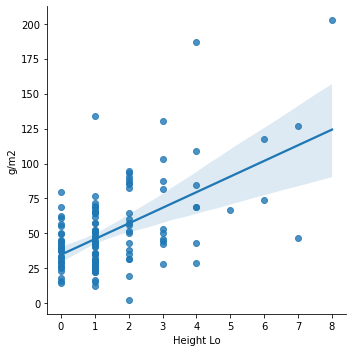

In [34]:
sns.lmplot(x='Height Lo',
y='g/m2',
data=robelclip)

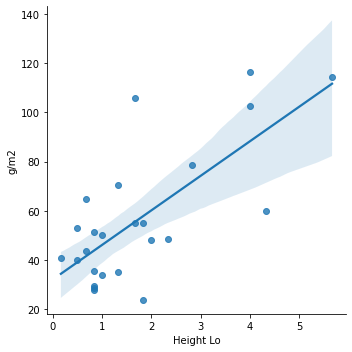

In [35]:
sns.lmplot(x='Height Lo',
y='g/m2',
data=robelclip.groupby(['Block', 'Paddock', 'Year']).mean())

In [36]:
import statsmodels.formula.api as smf

In [37]:
mod_bm = smf.ols("Q('g/m2') ~ Q('Height Lo') + Q('Height Hi')", data=robelclip.groupby(['Block', 'Paddock', 'Year']).mean()).fit()
mod_bm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Q('g/m2')   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     16.46
Date:                Tue, 22 Feb 2022   Prob (F-statistic):           4.26e-05
Time:                        08:48:53   Log-Likelihood:                -106.26
No. Observations:                  25   AIC:                             218.5
Df Residuals:                      22   BIC:                             222.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         19.2512      8.438      2.281      0.033       1.752      36.751
Q('Height Lo')     6.9741      4.258      1.638      0.116      -1.857      15.805
Q('Height Hi')     1.8245      0.866      2.106      0.047       0.028       3.622
==============================================================================
Omnibus:                        1.071   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.585   Jarque-Bera (JB):                0.289
Skew:                          -0.225   Prob(JB):                        0.865
Kurtosis:                       3.276   Cond. No.                         36.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
robel['Predicted']=mod_bm.predict(robel)
robel.head()

,Date1,Block,Paddock,Plot,Direction,Location,Height Hi,Height Lo,Robel_loc,Year,Predicted
0,2019-06-25,1,1,NaN,NaN,1,28.0,10.0,1-1-1,2019,140.079140
1,2019-06-25,1,1,NaN,NaN,2,40.0,6.0,1-1-2,2019,134.077473
2,2019-06-25,1,1,NaN,NaN,3,34.0,20.0,1-1-3,2019,220.767034
3,2019-06-26,1,1,NaN,NaN,1,38.0,5.0,1-1-1,2019,123.454317
4,2019-06-26,1,1,NaN,NaN,2,26.0,14.0,1-1-2,2019,164.326287


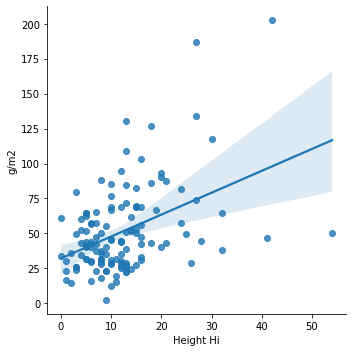

In [39]:
sns.lmplot(x='Height Hi',
y='g/m2',
data=robelclip)

In [40]:
display(robelclip[(robelclip['Height Lo'] == 1.0) & (robelclip['g/m2'] > 120)])

,Year_x,Block,Paddock,Plot_x,Location_x,GrazingTrt2019,GrazingTrt2020,GrazingTrt2021,g/m2,Robel_loc,Date,Date1,Plot,Direction,Location,Height Hi,Height Lo,Year
11,2019,2,1,1,1,M,NaN,NaN,134.2,2-1-1,2019-08-01,2019-07-04,NaN,NaN,1,27.0,1.0,2019.0
